## Imports

In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from qibo.models import Circuit
from qibo import gates, matrices
from qibo.optimizers import optimize
from qibo.hamiltonians import Hamiltonian
import qibo
qibo.set_device('/CPU:0')

[Qibo 0.1.7.dev0|INFO|2021-10-23 10:06:42]: Using qibojit backend on /GPU:0
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Setup

In [2]:
beta = 1
layers = 2

In [3]:
def target(x, beta):
    return np.exp(-beta*(x+1))

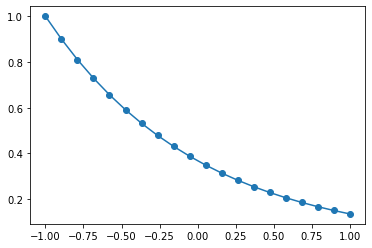

In [4]:
x = np.linspace(-1,1,20)
y = target(x, beta=1)
plt.plot(x,y,'o-')

## Allocate circuit

In [5]:
model = Circuit(1)
for l in range(layers):
    model.add(gates.RZ(0, theta=0))
    model.add(gates.RY(0, theta=0))
    model.add(gates.RZ(0, theta=0))
    model.add(gates.RZ(0, theta=0))
    model.add(gates.RY(0, theta=0))

## Define Z measurement hamiltonian

In [6]:
def hamiltonian(nqubits, z_qubit=0):
    """Precomputes Hamiltonian.
    Args:
        nqubits (int): number of qubits.
        z_qubit (int): qubit where the Z measurement is applied, must be z_qubit < nqubits
    Returns:
        An Hamiltonian object.
    """
    eye = matrices.I
    if z_qubit == 0:
        h = matrices.Z
        for _ in range(nqubits - 1):
            h = K.np.kron(eye, h)

    elif z_qubit == nqubits - 1:
        h = eye
        for _ in range(nqubits - 2):
            h = K.np.kron(eye, h)
        h = K.np.kron(matrices.Z, h)
    else:
        h = eye
        for _ in range(nqubits - 1):
            if _ + 1 == z_qubit:
                h = K.np.kron(matrices.Z, h)
            else:
                h = K.np.kron(eye, h)
    return Hamiltonian(nqubits, h)

## Predict

In [7]:
def predict(x, params, circuit, hamiltonian):
    ypred = np.zeros(x.shape)
    for i, ix in enumerate(x):
        lparams = params.copy()
        for l in range(layers):
            lparams[0 + l*5] = (lparams[0 + l*5] + lparams[2 + l*5]) / 2.0
            lparams[2 + l*5] = (lparams[0 + l*5] - lparams[2 + l*5]) / 2.0            
            lparams[3 + l*5] *= ix
        circuit.set_parameters(lparams)
        final_state = circuit()
        ypred[i] = hamiltonian.expectation(final_state)
    return ypred

## Loss

In [8]:
def loss(params, circuit, hamiltonian, x):
    ypred = predict(x, params, circuit, hamiltonian)
    loss = np.mean(np.square(y - ypred))
    return loss

## Train

In [9]:
H = hamiltonian(1)
np.random.seed(0)
init = np.random.rand(len(model.get_parameters()))
result, parameters, extra = optimize(loss, init, args=(model, H, x), method='BFGS')

## Check

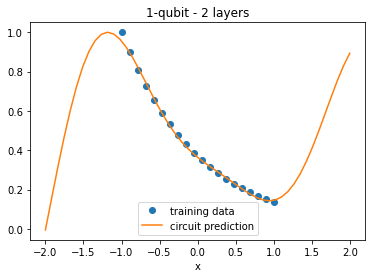

In [10]:
ypred = predict(x, parameters, model, H)

xx = np.linspace(-2,2,50)
yy = predict(xx, parameters, model, H)

plt.plot(x,y,'o', label='training data')
plt.plot(xx, yy,'-', label='circuit prediction')

plt.title(f'1-qubit - {layers} layers')
plt.xlabel('x')
plt.legend()